<a href="https://colab.research.google.com/github/ethansong206/Climate-Plus-Project/blob/main/DataCleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title Import packages
import pandas as pd
import numpy as np
from datetime import datetime
import re
import seaborn
import matplotlib.pyplot as plt
from google.colab import files

In [3]:
#@title Load csv and clean locations + dates
DiningDataFull = pd.read_csv('/content/drive/MyDrive/Data+/Climate+ Data 2019 thru 2023.csv',
                             dtype = {'Priority 1': str, 'Priority 2': str,
                                      'Priority 3': str})
#print(DiningDataFull['Unit Name'].value_counts()) # Show how many entries there are of each location

#below code to make 'Unit Name' column easier to handle
#can add more lines given more locations
def location_rename(location):
    if("Marketplace" in location): #Combine data for Marketplace Kitchen and Marketplace Special Event
        return "Marketplace"
    if("Marine Lab" in location):
        return "DuML"
    if("Trinity" in location):
        return "Trinity"
    if("Freeman" in location):
        return "Freeman"
    return None

DiningDataFull['Unit Name'] = DiningDataFull.apply(lambda d: location_rename(d['Unit Name']), axis = 1)

DiningDataFull['Purchase Date'] = DiningDataFull.apply(lambda d: datetime.strptime(d['Purchase Date'], '%m/%d/%Y').date(), axis = 1)

print("Rows in DiningDataFull: ", DiningDataFull.shape[0])

Rows in DiningDataFull:  90534


---
Extract the unit names for each item into a new column called `Unit`, then rename each unit into a more simple label (i.e. LB CS to LB). Convert cans and bottle cases into the equivalent value in OZ.

Extract the simplified item name from `Vendor Item Description` into a new column called `Item Name`.

---
Note on Exclusion: Some units are left out in this first calculation of emissions as they are either not directly food (i.e. gloves) or are too difficult to go through individually and find a measurement that is not ambiguous. The total number of entries left out is 12171. **The number of non-food items in this amount can be calculated later.**

---
Note on Conversions: The column `Vendor Item Purchase Unit` is in the format x/y n which should be read as x bags of y units of n food.

---

In [4]:
#@title Extract and clean units and item names
#this code extracts just the unit information
DiningDataFull['Unit'] = DiningDataFull['Vendor Item Purchase Unit'].str.extract(r" ?([A-Za-zÀ-ÿ ]*)$").astype(str)
#below code to simplify redundant labels (i.e. LB CS to LB)
#first, make it all uppercase to simplify code
DiningDataFull['Unit'] = DiningDataFull['Unit'].str.upper()
def unit_rename(unit):
    if('LB' in unit) | ('POUND' in unit):
        return 'LB'
    if('OZ' in unit) | (' Z' in unit):
        return 'OZ'
    if('GA' in unit) | ('GAL' in unit):
        return 'GA'
    if('QT' in unit):
        return 'QT'
    if('PT' in unit) | ('PINT' in unit):
        return 'PT'
    if('LT' in unit):
        return 'LT'
    if('BU' in unit) | ('Bushel' in unit): #bushels
        return 'BU'
    if('KG' in unit):
        return 'KG'
    if('GR' in unit): #grams
        return 'GR'
    if('ML' in unit): #milliliters
        return 'ML'
    if('CN' in unit) | ('Can' in unit):
        return 'CN'
    if('BOTTLE CASE' in unit):
        return 'Bottle Case'
    return None
#Notes: Bottle Case is 64 oz each, find # of can and translate to oz, anything with EA is not included for now (~9000)
DiningDataFull['Unit'] = DiningDataFull.apply(lambda d: unit_rename(d['Unit']), axis = 1)

#convert cans to OZ
#using estimates for weight of cans through https://food.unl.edu/article/how-interpret-can-size-numbers
DiningDataFull = DiningDataFull.replace({'#10 CN' : '110.5 OZ'}, regex = True)
DiningDataFull = DiningDataFull.replace({'#10 Can' : '110.5 OZ'}, regex = True)
DiningDataFull = DiningDataFull.replace({'#300 CN' : '15 OZ'}, regex = True)
DiningDataFull = DiningDataFull.replace({'CN' : 'OZ'})
#convert bottle case to OZ
DiningDataFull = DiningDataFull.replace({' Bottle Case' : '/64 OZ'}, regex = True)
DiningDataFull = DiningDataFull.replace({'BOTTLE CASE' : 'OZ'})

#extract clean item names
#make everything uppercase and remove zz's in front of some of the item descriptions
DiningDataFull['Vendor Item Description'] = DiningDataFull['Vendor Item Description'].str.upper()
DiningDataFull['Vendor Item Description'] = DiningDataFull['Vendor Item Description'].apply(lambda x: re.sub(r'^ZZ ', '', x))
DiningDataFull['Vendor Item'] = DiningDataFull['Vendor Item Description'].str.extract(r'(.*),')
DiningDataFull['Vendor Item'] = DiningDataFull['Vendor Item'].str.upper()
print(DiningDataFull.head())

     Unit Name    Vendor Purchase Date Vendor Item ID  \
0  Marketplace  US Foods    2019-07-01        5018999   
1  Marketplace  US Foods    2019-07-01        5400692   
2  Marketplace  US Foods    2019-07-01        8012643   
3  Marketplace  US Foods    2019-07-01         731349   
4  Marketplace  US Foods    2019-07-01          68106   

                             Vendor Item Description  \
0  POTATO, FRENCH-FRY 3/4 X3/8 STEAK CUT SKIN-ON ...   
1  POTATO, FRENCH-FRY SPIRAL COATED SEASONED TFF ...   
2  POTATO, FRENCH-FRY 1/2 CRINKLE-CUT TFF EXTRA-L...   
3                POTATO, HASH BROWN SHRED COOKED REF   
4    POTATO, TATER NUGGET PARFRIED FROZEN HASH BROWN   

  Vendor Item Purchase Unit                              Product Group  \
0                    6/5 LB  APPETIZERS, ENTREES, & POTATOES REF & FZN   
1                    6/5 LB  APPETIZERS, ENTREES, & POTATOES REF & FZN   
2                  6/4.5 LB  APPETIZERS, ENTREES, & POTATOES REF & FZN   
3                   2/10

---
Make a new column called `Total Amount` for the total amount of food in the current unit of measurement, before converting to grams. Make a new column called `Total Amount(g)` for converting all units to the equivalent value in grams, then filter out main descriptor word(s) in `Vendor Item Description` into a new column called `Food Name`.

---

Take the column with units in grams and multiply by the `Receive Quantity` if provided into a new column called `Total Grams`. If there is no value in `Receive Quantity`, then assume it is the value 1.

---
Note on Conversions: Most of these conversions are estimated to the nearest tenth. **More accurate calculations can be found later**

---

In [5]:
#@title DDReduced and DDReducedLabeled
#make a new dataset for just entries with known units
DDReduced = DiningDataFull[DiningDataFull['Unit'].notna()]
#print(DDReduced.head())

#make csv to manually edit unclean entries
#DDReduced.to_csv('DDReduced.csv', encoding = 'utf-8-sig')
#files.download('DDReduced.csv')

DDReducedLabeled = pd.read_csv('/content/drive/MyDrive/Data+/DDReducedLabeled.csv')

DDReducedLabeled['Purchase Date'] = DDReducedLabeled.apply(lambda d: datetime.strptime(d['Purchase Date'], '%m/%d/%Y').date(), axis = 1)

In [6]:
#@title Find total amount of food
#find total amount of food in original unit before converting to grams
DDReduced = DDReduced.copy()
DDReduced['Total Amount'] = DDReduced['Vendor Item Purchase Unit'].str.extract(r'^[a-zA-Z]* ?-?/? ?([0-9]*/?[0-9.]*-?[0-9.]*)')
DDReduced['Range'] = DDReduced['Total Amount'].str.extract(r'([0-9.]*-[0-9.]*)')
DDReduced['Range'] = DDReduced['Range'].astype(str)
DDReduced['Range'] = DDReduced['Range'].replace({'nan' : '0'})
DDReduced['Range Average'] = DDReduced['Range'].replace({'-' : '+'}, regex = True)
DDReduced['Range Average'] = DDReduced.apply(lambda d: eval(d['Range Average']), axis = 1)
DDReduced['Range Average'] /= 2

has_slash = ~(DDReduced['Total Amount'].str.contains('/')) & (DDReduced['Total Amount'].str.len() > 0)
DDReduced.loc[has_slash, 'Total Amount'] = (
    '1/' + DDReduced.loc[has_slash, 'Total Amount']
)

has_range = DDReduced['Total Amount'].str.contains('-')
DDReduced.loc[has_range, 'Total Amount'] = (
    DDReduced.loc[has_range, 'Total Amount'].str.split('/').str[0]
    + '/'
    + DDReduced.loc[has_range, 'Range Average'].astype(str)
)

just_unit = (DDReduced['Total Amount'] == '') & ~(DDReduced['Vendor Item Purchase Unit'].isna())
DDReduced.loc[just_unit, 'Total Amount'] = '1'

DDReduced = DDReduced.drop(['Range', 'Range Average'], axis = 1)

DDReduced['Total Amount'] = DDReduced['Total Amount'].replace({'' : '0'})
DDReduced['Receive Quantity'] = DDReduced['Receive Quantity'].fillna(0)
DDReduced = DDReduced[DDReduced['Receive Quantity'] != 0] #get rid of any rows that were not received
DDReduced['Total Amount'] = DDReduced['Total Amount'].replace({'/' : '*'}, regex = True)
DDReduced['Total Amount'] = DDReduced.apply(lambda d: eval(d['Total Amount']), axis = 1)
DDReduced['Total Amount'] = DDReduced['Total Amount'].astype(float) * DDReduced['Receive Quantity'].astype(float)

In [7]:
#@title Convert all units to grams
def convert_units(row):
    if row['Unit'] == 'LB':
        return row['Total Amount'] * 453.6
    if row['Unit'] == 'OZ':
        return row['Total Amount'] * 28.35
    if row['Unit'] == 'GA':
        return row['Total Amount'] * 3785.4 #assuming density of water, most drinks are MORE dense so number is underestimate
    if row['Unit'] == 'QT':
        return row['Total Amount'] * 3785.4 / 4
    if row['Unit'] == 'PT':
        return row['Total Amount'] * 3785.4 / 8
    if (row['Unit'] == 'LT') | (row['Unit'] == 'KG'):
        return row['Total Amount'] * 1000 #also assuming density of water, most drinks MORE dense
    if (row['Unit'] == 'ML') | (row['Unit'] == 'G'):
        return row['Total Amount'] * 453.6
    return 0
DDReduced['Total Amount(kg)'] = DDReduced.apply(convert_units, axis = 1) / 1000

#modify `Product Group` column
DDReduced = DDReduced[DDReduced['Product Group'].notna()]
DDReduced['Product Group'] = DDReduced['Product Group'].str.upper() #make uppercase to simplify code

<ipython-input-7-a9685a9ad7cb>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DDReduced['Product Group'] = DDReduced['Product Group'].str.upper() #make uppercase to simplify code


In [8]:
#@title Excluded rows
print("Excluded rows: ", DiningDataFull.shape[0] - DDReduced.shape[0])
#print(DDReduced.head())

Excluded rows:  17161


---
#NLP

Come back later and try this, too difficult for now
---

In [9]:
#@title NLP packages
# from google.colab import files
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.preprocessing import LabelEncoder
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report

In [10]:
#@title NLP labeled data
#Create training set with ~10000 random entries
#DDtest = DDReduced.sample(10000)
#DDtest.to_csv('DDtest.csv', encoding = 'utf-8-sig')
#files.download('DDtest.csv')

# DDLabeled = pd.read_csv('DDLabeled.csv')

# print(DDLabeled.head())

#Notes on labels:
#syrup is 2/3 sugar 1/3 water for emissions
#many vegetables are labeled "Leafy greens" for now
#smoothies are labeled smoothie for now, can find fruits in each or average smoothie emissions later
#mushrooms need emissions numbers
#fruit is used to label misc less-common fruits
#avocados need emission numbers
#dressings need emission numbers
#squashes need emission numbers

In [11]:
#@title NLP model
# import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from sklearn.preprocessing import LabelEncoder

# # Preprocess the data
# text_data = DDLabeled['Vendor Item Description']
# labels = DDLabeled['Product Group']

# # Label encode the target variable
# label_encoder = LabelEncoder()
# labels = label_encoder.fit_transform(labels)

# # Tokenize the text data
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(text_data)
# vocab_size = len(tokenizer.word_index) + 1

# # Convert text to sequences
# sequences = tokenizer.texts_to_sequences(text_data)

# # Pad sequences to have equal length
# max_sequence_length = max(len(seq) for seq in sequences)
# padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# # Split the data into training and testing sets
# train_size = int(0.8 * len(padded_sequences))
# train_text = padded_sequences[:train_size]
# train_labels = labels[:train_size]
# test_text = padded_sequences[train_size:]
# test_labels = labels[train_size:]

# # Define the neural network architecture
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, 100, input_length=max_sequence_length),
#     tf.keras.layers.LSTM(64),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
# ])

# # Compile the model
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Train the model
# model.fit(train_text, train_labels, epochs=20, batch_size=32, validation_data=(test_text, test_labels))

In [12]:
#@title NLP testing
# # Evaluate the model
# loss, accuracy = model.evaluate(test_text, test_labels)
# print('Test Loss:', loss)
# print('Test Accuracy:', accuracy)

# # Make predictions on new data
# new_text = ['BEET, WHOLE PEELED COOKED 17.6 OZ VACUUM-PACK REF', 'BEIGELS CHALLAH']
# new_sequences = tokenizer.texts_to_sequences(new_text)
# new_padded_sequences = pad_sequences(new_sequences, maxlen=max_sequence_length)
# predictions = model.predict(new_padded_sequences)
# predicted_labels = label_encoder.inverse_transform(tf.argmax(predictions, axis=1))
# print('Predicted Labels:', predicted_labels)

In [13]:
#@title Copy manually labeled data
#last time manually labeled was 6/21/23
DDReduced = DDReducedLabeled

In [79]:
#@title Explore labeled data
#print(DDReduced['Vendor Item'].value_counts())
print(DDReduced['Vendor Item Grouped'].value_counts()[25:75])

COOKIE                 612
CHIP                   548
TOFU                   506
SAUSAGE                407
SODA                   372
COFFEE                 331
CHOCOLATE              298
WATER                  290
BUTTER                 234
VEGETABLE BASE         193
WINE                   164
VINEGAR                155
TEA BAG                146
CHICKEN BASE           140
TEMPEH                 133
SPRING ROLL            122
BEEF BASE              118
CLAM SOUP               94
CRAB SOUP               88
LOBSTER SOUP            82
CHEESE SUB              76
CHOCOLATE PIE           70
MEATBALL                63
SNACK BAR               61
BOSTOM CREAM PIE        58
EGG ROLL                51
COOKIES & CREAM PIE     48
VEGETABLE SOUP          37
MANICOTTI               34
LASAGNA (MEAT)          33
LAMB                    31
DESSERT BAR             31
CURRY BASE              29
MUSHROOM RAVIOLI        29
MARGARINE               28
CHEESE RAVIOLI          28
VANILLA PUDDING         24
S

In [77]:
#@title Item name cleaning
DDReduced['Vendor Item Grouped'] = DDReduced['Vendor Item']

def group_items(item):
    if(item == 'POTATO') | (item == 'CARROT') | (item == 'ONION') | \
      (item == 'SWEET POTATO') | (item == 'GARLIC') | (item == 'BEET') | \
      (item == 'TURNIP') | (item == 'YUCCA') | (item == 'RADISH') | \
      (item == 'SWEET POTATO PIE'):
        return 'ROOT VEGETABLE'

    if(item == 'CEREAL') | (item == 'FLOUR') | (item == 'CORN STARCH') | \
      (item == 'QUINOA') | (item == 'CORNMEAL') | (item == 'BARLEY') | \
      (item == 'SUNFLOWER SEED') | (item == 'YEAST') | (item == 'CRACKER'):
        return 'GRAIN'

    if(item == 'MUFFIN') | (item == 'CAKE') | (item == 'BAGEL') | \
      (item == 'CROISSANT') | (item == 'BISCUIT') | (item == 'DONUT') | \
      (item == 'DANISH') | (item == 'PANCAKE') | (item == 'HUSH PUPPY') | \
      (item == 'WAFFLE') | (item == 'BREADER') | (item == 'SCONE') | \
      (item == 'PIE CRUST') | (item == 'STUFFING') | (item == 'CROUTON') | \
      (item == 'CORNBREAD') | (item == 'CHURRO') | (item == 'DOUGH') | \
      (item == 'BABKA') | (item == 'MATZO'):
        return 'BREAD'

    if(item == 'TOMATO') | (item == 'STRAWBERRY') | (item == 'APPLE') | \
      (item == 'BANANA') | (item == 'ORANGE') | (item == 'GRAPE') | \
      (item == 'BLUEBERRY') | (item == 'MANGO') | (item == 'FRUIT MIX') | \
      (item == 'STRAWBERRY BANANA') | (item == 'PINEAPPLE') | \
      (item == 'CRANBERRY') | (item == 'PEACH') | (item == 'ORANGE MANGO') | \
      (item == 'BERRY MIX') | (item == 'LIME') | (item == 'PLANTAIN') | \
      (item == 'APPLE PIE') | (item == 'ORANGE PEACH') | (item == 'AVOCADO') | \
      (item == 'LEMON') | (item == 'LIME PIE') | (item == 'CHERRY PIE') | \
      (item == 'APRICOT') | (item == 'COCONUT') | (item == 'BLACKBERRY') | \
      (item == 'STRAWBERRY KIWI') | (item == 'RASPBERRY') | (item == 'PEAR') | \
      (item == 'BANANA PUDDING') | (item == 'PEACH PIE') | \
      (item == 'BLUEBERRY PIE') | (item == 'CHERRY') | (item == 'FIG') | \
      (item == 'RAISIN'):
        return 'FRUIT'

    if(item == 'SEASONING') | (item == 'BASIL') | (item == 'PARSLEY') | \
      (item == 'CILANTRO') | (item == 'SALT') | (item == 'GINGER') | \
      (item == 'FLAVORING') | (item == 'THYME') | (item == 'ROSEMARY') | \
      (item == 'MINT') | (item == 'MUSTARD GREENS') | (item == 'CHIVE') | \
      (item == 'SAGE'):
        return 'SPICES'

    if(item == 'SAUCE') | (item == 'DRESSING') | (item == 'MAYONNAISE') | \
      (item == 'KETCHUP') | (item == 'SPREAD') | (item == 'TOPPING') | \
      (item == 'SALSA') | (item == 'MUSTARD') | (item == 'JAM'):
        return 'CONDIMENTS'

    if(item == 'LETTUCE') | (item == 'BELL PEPPER') | (item == 'BROCCOLI') | \
      (item == 'VEGETABLE MIX') | (item == 'CORN') | (item == 'SQUASH') | \
      (item == 'ZUCCHINI') | (item == 'SPINACH') | (item == 'ASPARAGUS') | \
      (item == 'CUCUMBER') | (item == 'CAULIFLOWER') | (item == 'CABBAGE') | \
      (item == 'BOK CHOY') | (item == 'PICKLE') | (item == 'OLIVE') | \
      (item == 'LASAGNA (VEGGIE)') | (item == 'BRUSSEL SPROUT') | \
      (item == 'JALAPENO PEPPER') | (item == 'COLLARD GREENS') | \
      (item == 'OKRA') | (item == 'BANANA PEPPER') | (item == 'EGGPLANT') | \
      (item == 'ARTICHOKE') | (item == 'CHILI PEPPER') | (item == 'RELISH') | \
      (item == 'CHIPOTLE PEPPER') | (item == 'COLESLAW') | (item == 'KALE') | \
      (item == 'WATER CHESTNUT') | (item == 'POBLANO PEPPER') | \
      (item == 'ARUGULA'):
        return 'VEGETABLE'

    if(item == 'BEAN') | (item == 'HUMMUS') | (item == 'GREEN BEAN') | \
      (item == 'PEA') | (item == 'CHICKPEA') | (item == 'EDAMAME') | \
      (item == 'LENTIL') | (item == 'FALAFEL') | (item == 'PEANUT BUTTER') | \
      (item == 'CAPER'):
        return 'LEGUMES'

    if(item == 'CHICKEN') | (item == 'TURKEY') | (item == 'DUCK'):
        return 'POULTRY'

    if(item == 'SYRUP') | (item == 'HONEY') | (item == 'VANILLA EXTRACT') | \
      (item == 'MARSHMALLOW') | (item == 'ICING') | (item == 'CANDY') | \
      (item == 'POPSICLE'):
        return 'SUGAR'

    if(item == 'BEEF SUB') | (item == 'CHICKEN SUB'):
        return 'MEAT SUB'

    if(item == 'MILK SOY') | (item == 'MILK OAT') | (item == 'MILK COCONUT') | \
      (item == 'MILK ALMOND') | (item == 'MILK RICE'):
        return 'MILK SUB'

    if(item == 'HAM') | (item == 'CORN DOG'):
        return 'PORK'

    if(item == 'SHRIMP') | (item == 'SALMON') | (item == 'COD') | \
      (item == 'CATFISH') | (item == 'MAHI MAHI') | (item == 'FLOUNDER') | \
      (item == 'TUNA') | (item == 'CRAB') | (item == 'SCALLOP'):
        return 'SEAFOOD'

    if(item == 'ICE CREAM') | (item == 'SOUR CREAM'):
        return 'CREAM'

    if(item == 'NOODLE'):
        return 'PASTA'

    if(item == 'PEPPERONI') | (item == 'SALAMI'):
        return 'SAUSAGE'

    if(item == 'CLEANING'):
        return 'NOT FOOD'

    return item
DDReduced['Vendor Item Grouped'] = DDReduced.apply(lambda d: group_items(d['Vendor Item']), axis = 1)

In [16]:
#@title Load emissions csv and create emission ratio variables
#read csv here when done
#_______________________

#CURRENT VALUES: from CO2 spreadsheet above (Poore and Nemecek 2018) (6/5/23)
#beef_emission_ratio = 21.3 #US for retail beef, 65% of CW, https://www.sciencedirect.com/science/article/pii/S0308521X18305675?via%3Dihub#s0085
beef_emission_ratio = 40 #UK beef
pork_emission_ratio = 10.7 #Ham (CO2)
poultry_emission_ratio = 4.9 #chicken for North America (PN18)
lamb_emission_ratio = 40.0 #using global avg, lower than europe avg.
seafood_emission_ratio = 13.6 #average of three common fish
eggs_emission_ratio = 3.7 #avg for US (CO2)(PN18)
meatsub_emission_ratio = 2.19 #(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9936781/ , Mejia et al., 2020)
meatball_emission_ratio = .5 * beef_emission_ratio + .5 * pork_emission_ratio
sausage_emission_ratio = 8.85 #Sausage (CO2)
#add more values here as the data gets more clean
#later, replace with newer spreadsheet

print("beef: ", beef_emission_ratio, 'kg CO2e/kg')
print("pork: ", pork_emission_ratio, 'kg CO2e/kg')
print("poultry: ", poultry_emission_ratio, 'kg CO2e/kg')
print("lamb: ", lamb_emission_ratio, 'kg CO2e/kg')
print("seafood: ", seafood_emission_ratio, 'kg CO2e/kg')
print("eggs: ", eggs_emission_ratio, 'kg CO2e/kg')
print("meatsub: ", meatsub_emission_ratio, 'kg CO2e/kg')
print("meatball: ", meatball_emission_ratio, 'kg CO2e/kg')
print("sausage: ", sausage_emission_ratio, 'kg CO2e/kg')

#print(CO2.head())

beef:  40 kg CO2e/kg
pork:  10.7 kg CO2e/kg
poultry:  4.9 kg CO2e/kg
lamb:  40.0 kg CO2e/kg
seafood:  13.6 kg CO2e/kg
eggs:  3.7 kg CO2e/kg
meatsub:  2.19 kg CO2e/kg
meatball:  25.35 kg CO2e/kg
sausage:  8.85 kg CO2e/kg


In [17]:
#@title Calculate Carbon Emissions
#only meats, meat alternatives, and eggs done so far
#print(DDReduced['Product Group'].value_counts())

def calc_emissions(row):
    if row['Product Group'] == 'BEEF':
        return row['Total Amount(kg)'] * beef_emission_ratio
    if row['Product Group'] == 'PORK':
        return row['Total Amount(kg)'] * pork_emission_ratio
    if row['Product Group'] == 'SEAFOOD':
        return row['Total Amount(kg)'] * seafood_emission_ratio
    if row['Product Group'] == 'MEAT SUBSTITUTE':
        return row['Total Amount(kg)'] * meatsub_emission_ratio
    if row['Product Group'] == 'LAMB':
        return row['Total Amount(kg)'] * lamb_emission_ratio
    if (row['Product Group'] == 'CHICKEN') | (row['Product Group'] == 'POULTRY') | \
       (row['Product Group'] == 'TURKEY') | (row['Product Group'] == 'DUCK'):
        return row['Total Amount(kg)'] * beef_emission_ratio
    if row['Product Group'] == 'EGGS':
        return row['Total Amount(kg)'] * eggs_emission_ratio
    if row['Product Group'] == 'MEATBALL':
        return row['Total Amount(kg)'] * meatball_emission_ratio
    if row['Product Group'] == 'SAUSAGE':
        return row['Total Amount(kg)'] * sausage_emission_ratio
    return 0

DDReduced['CO2e(kg)'] = DDReduced.apply(calc_emissions, axis = 1)

total_food_amount_kg = DDReduced['Total Amount(kg)'].sum()
total_food_amount_calced_kg = DDReduced[DDReduced['CO2e(kg)'] != 0]['Total Amount(kg)'].sum()
percent_food_calced = total_food_amount_calced_kg / total_food_amount_kg * 100

print('The percentage of food (by weight) with calculated carbon emissions so far is: ', percent_food_calced, "%")

The percentage of food (by weight) with calculated carbon emissions so far is:  63.201983204801756 %


In [18]:
#@title Create separated dataframes
location_col = DDReduced['Unit Name']
DDMarketplace = DDReduced[location_col == "Marketplace"]
DDDuML = DDReduced[location_col == "DuML"]
DDTrinity = DDReduced[location_col == "Trinity"]
DDFreeman = DDReduced[location_col == "Freeman"]

date_col = DDReduced['Purchase Date']
DDFY20 = DDReduced[(date_col >= pd.Timestamp(2019, 7, 1).date()) & (date_col < pd.Timestamp(2020, 6, 30).date())]
DDFY21 = DDReduced[(date_col >= pd.Timestamp(2020, 7, 1).date()) & (date_col < pd.Timestamp(2021, 6, 30).date())]
DDFY22 = DDReduced[(date_col >= pd.Timestamp(2021, 7, 1).date()) & (date_col < pd.Timestamp(2022, 6, 30).date())]
DDFY23 = DDReduced[(date_col >= pd.Timestamp(2022, 7, 1).date()) & (date_col < pd.Timestamp(2023, 6, 30).date())]

In [19]:
#@title Analysis
#later, download a csv from previous code and move this to a new notebook
total_food_emissions_2022 = DDFY22['CO2e(kg)'].sum()
total_duke_emissions_2022 = 194346000 #in kg, from 2022 GHG emissions

total_food_amount_kg_2022 = DDFY22['Total Amount(kg)'].sum()
total_food_amount_calced_kg_2022 = DDFY22[DDFY22['CO2e(kg)'] != 0]['Total Amount(kg)'].sum()
percent_food_calced_2022 = total_food_amount_calced_kg_2022 / total_food_amount_kg_2022 * 100

print('The percentage of food (by weight) with calculated carbon emissions so far in 2022 is: ', percent_food_calced_2022, "%")
print('')
print("Of what has been calculated, food is ", total_food_emissions_2022 / total_duke_emissions_2022 * 100, "% of Duke's total GHG emissions in 2022")
print("The value in Metric Tons is: ", total_food_emissions_2022 / 1000)
print("If food is not included in Duke's calculations, then the reported amount is: ", total_duke_emissions_2022 / (total_duke_emissions_2022 + total_food_emissions_2022) * 100, "% of the real total emissions")

The percentage of food (by weight) with calculated carbon emissions so far in 2022 is:  62.54326134096214 %

Of what has been calculated, food is  28.9413445855332 % of Duke's total GHG emissions in 2022
The value in Metric Tons is:  56246.34554820036
If food is not included in Duke's calculations, then the reported amount is:  77.55464340893779 % of the real total emissions


Text(0.5, 1.0, '(Only meat products have been calculated so far)')

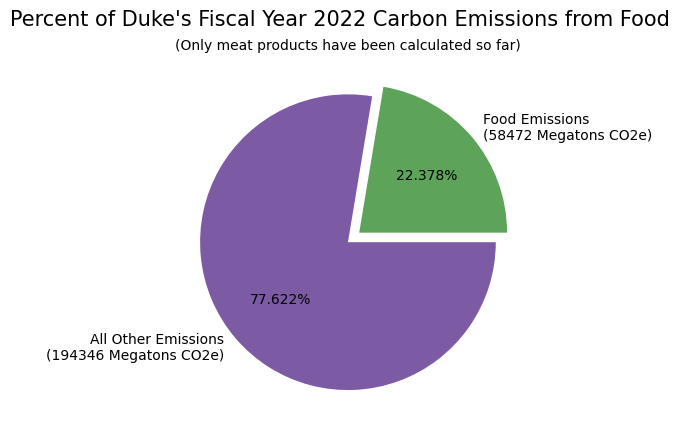

In [20]:
#@title Visualize
data = [22.378, 77.622]
explode = [0.1, 0]
keys = ['Food Emissions\n(58472 Megatons CO2e)', \
        'All Other Emissions\n(194346 Megatons CO2e)']

colors = ['#5da45a', '#7c5aa4']

plt.pie(data, labels=keys, colors=colors, autopct='%.3f%%', \
        explode = explode)
plt.suptitle('Percent of Duke\'s Fiscal Year 2022 Carbon Emissions from Food', fontsize = 15)
plt.title('(Only meat products have been calculated so far)', fontsize = 10)

#plt.show()

In [21]:
#DD22.to_csv('DD22.csv', encoding = 'utf-8-sig')
#files.download('DD22.csv')